In [1]:
from carpool_data import posts, derived_posts

In [2]:
import pandas as pd
import matplotlib as mpl
import string
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
#first feature will be character count of the original post, transformed
posts["post_length"] = posts["message"].apply(lambda x: len(x))
posts["length_transformed"] = scipy.stats.boxcox(posts["post_length"])[0]

#2nd feature will be number of capitals, transformed
def num_of_caps(string):
    return sum(1 for c in string if c.isupper())

posts["number_of_caps"] = posts["message"].apply(lambda x: num_of_caps(x))
posts["caps_transformed"] = scipy.stats.boxcox(posts["number_of_caps"] + 1)[0]

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from carpool_data import posts, derived_posts
import string

#count vectorization

def split_by_comma(x):
    return x.split(",")

count_vect = CountVectorizer(analyzer = split_by_comma)

#the training set of posts for number of routes
#in particular, the classified posts for number of routes
posts_tr_routes = posts[~posts["number_of_routes"].isnull()].reset_index(drop = True)

X_count_routes = count_vect.fit_transform(posts_tr_routes["tockenized_message"])
X_count_feat = pd.DataFrame(X_count_routes.toarray())

In [5]:
#add the features to the document turn matrix
#once again this is only for the classified ones
X_count_feat["length_transformed"] = posts_tr_routes["length_transformed"]
X_count_feat["caps_transformed"] = posts_tr_routes["caps_transformed"]
Y = posts_tr_routes["number_of_routes"]

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score

rf = RandomForestClassifier()
param = {'n_estimators': [10,150,300], 'max_depth': [60,90,None]}

In [7]:
gs = GridSearchCV(rf, param, cv = 5, n_jobs = -1, return_train_score= True)
gs_fit = gs.fit(X_count_feat, Y)
pd.DataFrame(gs_fit.cv_results_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.025051,0.002216,0.932341,0.996269,60,10,"{'max_depth': 60, 'n_estimators': 10}",8,0.913333,0.993209,...,0.925676,1.000000,0.965753,0.996627,0.944828,1.000000,0.002850,3.962099e-04,0.020167,0.003463
1,0.369172,0.016039,0.941813,1.000000,60,150,"{'max_depth': 60, 'n_estimators': 150}",2,0.926667,1.000000,...,0.932432,1.000000,0.972603,1.000000,0.965517,1.000000,0.102093,3.701818e-03,0.022943,0.000000
2,0.951331,0.034292,0.941813,1.000000,60,300,"{'max_depth': 60, 'n_estimators': 300}",2,0.926667,1.000000,...,0.945946,1.000000,0.972603,1.000000,0.951724,1.000000,0.042218,5.010180e-03,0.020523,0.000000
3,0.053542,0.003209,0.933694,0.997298,90,10,"{'max_depth': 90, 'n_estimators': 10}",6,0.940000,1.000000,...,0.912162,0.998308,0.958904,0.996627,0.944828,0.994949,0.007438,4.007872e-04,0.018302,0.001719
4,0.525999,0.018850,0.933694,1.000000,90,150,"{'max_depth': 90, 'n_estimators': 150}",6,0.933333,1.000000,...,0.925676,1.000000,0.958904,1.000000,0.958621,1.000000,0.041359,2.720202e-03,0.024311,0.000000
5,1.013496,0.035695,0.935047,1.000000,90,300,"{'max_depth': 90, 'n_estimators': 300}",5,0.920000,1.000000,...,0.918919,1.000000,0.972603,1.000000,0.951724,1.000000,0.047121,6.391513e-03,0.022956,0.000000
6,0.038703,0.003009,0.925575,0.996286,None,10,"{'max_depth': None, 'n_estimators': 10}",9,0.926667,0.998302,...,0.925676,0.994924,0.938356,0.993255,0.931034,0.994949,0.001629,5.519789e-07,0.010533,0.002477
7,0.482286,0.020652,0.937754,1.000000,None,150,"{'max_depth': None, 'n_estimators': 150}",4,0.913333,1.000000,...,0.939189,1.000000,0.972603,1.000000,0.958621,1.000000,0.046787,7.732415e-03,0.025357,0.000000
8,0.805541,0.022073,0.943166,1.000000,None,300,"{'max_depth': None, 'n_estimators': 300}",1,0.920000,1.000000,...,0.939189,1.000000,0.972603,1.000000,0.965517,1.000000,0.043911,2.108900e-03,0.022141,0.000000


In [8]:
#since we dont have enough manual classifications,
#we will just differentiate between 1 and more than 1 route
Y2 = [0] * len(Y)
for i  in range(0,len(Y)):
    if(Y[i] > 1):
        Y2[i] = 2    
    else:
        Y2[i] = 1 

gs_fit = gs.fit(X_count_feat, Y2)
pd.DataFrame(gs_fit.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.024052,0.002001,0.933694,0.995605,60,10,"{'max_depth': 60, 'n_estimators': 10}",9,0.946309,0.998305,...,0.918367,0.993243,0.972789,0.994932,0.952381,0.994932,0.003293,0.000012,0.032422,0.001720
1,0.436748,0.018449,0.949932,1.000000,60,150,"{'max_depth': 60, 'n_estimators': 150}",3,0.946309,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.965986,1.000000,0.094266,0.003729,0.033012,0.000000
2,1.050997,0.035094,0.948579,1.000000,60,300,"{'max_depth': 60, 'n_estimators': 300}",5,0.953020,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.965986,1.000000,0.044730,0.002764,0.037865,0.000000
3,0.051538,0.003812,0.937754,0.993911,90,10,"{'max_depth': 90, 'n_estimators': 10}",8,0.926174,0.996610,...,0.945578,0.994932,0.986395,0.998311,0.959184,0.988176,0.010158,0.000748,0.038212,0.003641
4,0.504542,0.020454,0.945873,1.000000,90,150,"{'max_depth': 90, 'n_estimators': 150}",6,0.946309,1.000000,...,0.938776,1.000000,0.993197,1.000000,0.965986,1.000000,0.012497,0.004375,0.035512,0.000000
5,0.945920,0.032082,0.953992,1.000000,90,300,"{'max_depth': 90, 'n_estimators': 300}",1,0.966443,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.959184,1.000000,0.027164,0.001681,0.030746,0.000000
6,0.040707,0.003612,0.939107,0.995944,None,10,"{'max_depth': None, 'n_estimators': 10}",7,0.953020,0.998305,...,0.931973,0.993243,0.979592,0.994932,0.959184,0.994932,0.002803,0.000801,0.036747,0.002024
7,0.455411,0.017446,0.953992,1.000000,None,150,"{'max_depth': None, 'n_estimators': 150}",1,0.966443,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.965986,1.000000,0.011280,0.001023,0.033550,0.000000
8,0.830608,0.028273,0.949932,1.000000,None,300,"{'max_depth': None, 'n_estimators': 300}",3,0.953020,1.000000,...,0.952381,1.000000,0.993197,1.000000,0.965986,1.000000,0.014815,0.001726,0.035401,0.000000


In [9]:
X_count2 = count_vect.fit(posts_tr_routes["tockenized_message"])
mes = "Test"
c = X_count2.transform([mes])
print(c)
#need to add the other 2 features into this

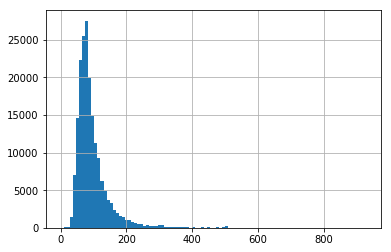

In [10]:
#a look at the distributions
posts["post_length"].hist(bins = 100)

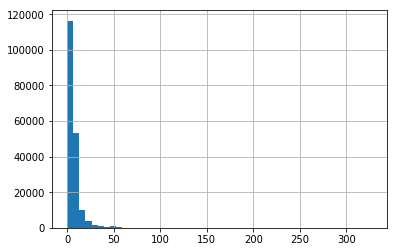

In [11]:
posts["number_of_caps"].hist(bins = 50)

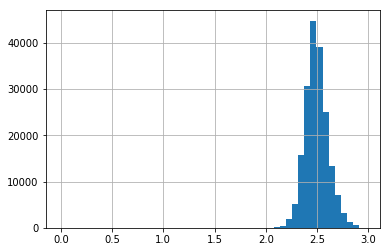

In [12]:
posts["length_transformed"].hist(bins=50)

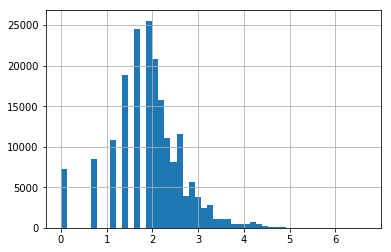

In [13]:
posts["caps_transformed"].hist(bins=50)